[View in Colaboratory](https://colab.research.google.com/github/nicewook/datascience_exercise/blob/master/part2_1.ipynb)

# 설문조사 응답분석 1
- 강좌링크: https://programmers.co.kr/learn/courses/21
- Part2.1: https://programmers.co.kr/learn/courses/21/lessons/937
- 유튜브: https://youtu.be/5hzB54yFvnw


In [0]:
# 노트북 안에서 그래프 그리는 magic
%matplotlib inline

# import the standard Python Scientific libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress Deprecation and Incorrect Isage Warnings - 워닝 지저분하게 뜨는거 표시하지 않기
import warnings
warnings.filterwarnings('ignore')


In [6]:
# Google Drive와 연결
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools

!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null

!apt-get update -qq 2>&1 > /dev/null

!apt-get -y install -qq google-drive-ocamlfuse fuse

from google.colab import auth

auth.authenticate_user()

from oauth2client.client import GoogleCredentials

creds = GoogleCredentials.get_application_default()

import getpass

!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL

vcode = getpass.getpass()

!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

gpg: keybox '/tmp/tmp95896jv_/pubring.gpg' created
gpg: /tmp/tmp95896jv_/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
# 폴더를 만들어서 구글 드라이브 연동
!mkdir -p drive 
!google-drive-ocamlfuse drive 

In [10]:
cd drive/kaggle/kaggle-survey-2017/

/content/drive/kaggle/kaggle-survey-2017


In [12]:
ls -al

total 28566
drwxr-xr-x 2 root root     4096 May 21 05:21 ./
drwxr-xr-x 2 root root     4096 May 21 05:19 ../
-rw-r--r-- 1 root root     1877 May 21 05:21 conversionRates.csv
-rw-r--r-- 1 root root  4303670 May 21 05:21 freeformResponses.csv
-rw-r--r-- 1 root root 24876561 May 21 05:22 multipleChoiceResponses.csv
-rw-r--r-- 1 root root    14619 May 22 00:09 part2-1.ipynb
-rw-r--r-- 1 root root     1032 May 21 05:21 RespondentTypeREADME.txt
-rw-r--r-- 1 root root       40 May 21 08:54 saveToDrive.txt
-rw-r--r-- 1 root root    42779 May 21 05:36 schema.csv
-rw-r--r-- 1 root root        0 May 21 06:53 test2.txt
-rw-r--r-- 1 root root        0 May 21 07:53 test3.txt
-rw-r--r-- 1 root root        0 May 21 06:52 test.txt


In [13]:
questions = pd.read_csv('schema.csv')  
print(questions.head()) # 질문들이 어떤게 있나 잠시 보자
print(questions.shape)  # 어떤 모양인지 보자

             Column                                           Question Asked
0      GenderSelect     Select your gender identity. - Selected Choice   All
1    GenderFreeForm  Select your gender identity. - A different ide...   All
2           Country          Select the country you currently live in.   All
3               Age                                   What's your age?   All
4  EmploymentStatus             What's your current employment status?   All
(290, 3)


In [15]:
# 판다스로 선다형 객관식 문제에 대한 응답을 가져옴
mcq = pd.read_csv('multipleChoiceResponses.csv', encoding="ISO-8859-1", low_memory=False)
mcq.shape

(16716, 228)

In [16]:
mcq.columns

Index([u'GenderSelect', u'Country', u'Age', u'EmploymentStatus',
       u'StudentStatus', u'LearningDataScience', u'CodeWriter',
       u'CareerSwitcher', u'CurrentJobTitleSelect', u'TitleFit',
       ...
       u'JobFactorExperienceLevel', u'JobFactorDepartment', u'JobFactorTitle',
       u'JobFactorCompanyFunding', u'JobFactorImpact', u'JobFactorRemote',
       u'JobFactorIndustry', u'JobFactorLeaderReputation',
       u'JobFactorDiversity', u'JobFactorPublishingOpportunity'],
      dtype='object', length=228)

In [17]:
mcq.head(10)

,GenderSelect,Country,Age,EmploymentStatus,StudentStatus,LearningDataScience,CodeWriter,CareerSwitcher,CurrentJobTitleSelect,TitleFit,...,JobFactorExperienceLevel,JobFactorDepartment,JobFactorTitle,JobFactorCompanyFunding,JobFactorImpact,JobFactorRemote,JobFactorIndustry,JobFactorLeaderReputation,JobFactorDiversity,JobFactorPublishingOpportunity
0,"Non-binary, genderqueer, or gender non-conforming",NaN,NaN,Employed full-time,NaN,NaN,Yes,NaN,DBA/Database Engineer,Fine,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Female,United States,30.0,"Not employed, but looking for work",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Somewhat important,NaN,NaN
2,Male,Canada,28.0,"Not employed, but looking for work",NaN,NaN,NaN,NaN,NaN,NaN,...,Very Important,Very Important,Very Important,Very Important,Very Important,Very Important,Very Important,Very Important,Very Important,Very Important
3,Male,United States,56.0,"Independent contractor, freelancer, or self-em...",NaN,NaN,Yes,NaN,Operations Research Practitioner,Poorly,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Male,Taiwan,38.0,Employed full-time,NaN,NaN,Yes,NaN,Computer Scientist,Fine,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Male,Brazil,46.0,Employed full-time,NaN,NaN,Yes,NaN,Data Scientist,Fine,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Male,United States,35.0,Employed full-time,NaN,NaN,Yes,NaN,Computer Scientist,Fine,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Female,India,22.0,Employed full-time,NaN,NaN,No,Yes,Software Developer/Software Engineer,Fine,...,Very Important,Somewhat important,Very Important,Somewhat important,Somewhat important,Not important,Very Important,Very Important,Somewhat important,Somewhat important
8,Female,Australia,43.0,Employed full-time,NaN,NaN,Yes,NaN,Business Analyst,Fine,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Male,Russia,33.0,Employed full-time,NaN,NaN,Yes,NaN,Software Developer/Software Engineer,Fine,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


  Running setup.py bdist_wheel for missingno ... - done
  Stored in directory: /content/.cache/pip/wheels/e7/f2/2a/767a612cde8834415d23ab484c5d069fcd0ab3a85052cda6a6
Successfully built missingno


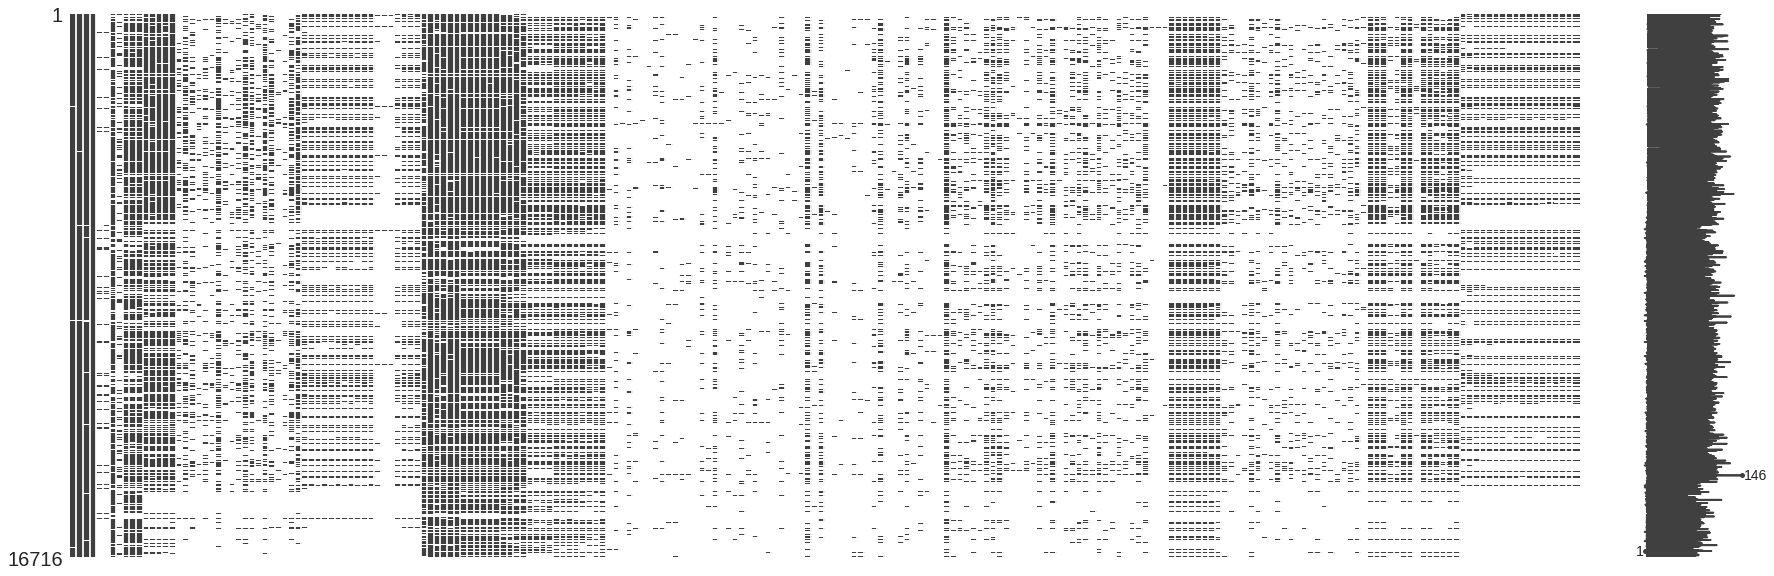

In [19]:
# missingno 는 NaN 데이터를 시각화해준다. 
!pip install missingno
import missingno as msno
msno.matrix(mcq, figsize=(30,10))

# 설문에 대한 통계를 내어보자

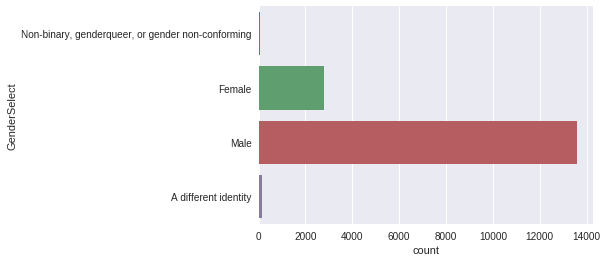

In [21]:
# 성별 통계
sns.countplot(y='GenderSelect', data=mcq)

In [33]:
# 국가별 응답수
con_df = pd.DataFrame(mcq['Country'].value_counts())
con_df

,Country
United States,4197
India,2704
Other,1023
Russia,578
United Kingdom,535
People 's Republic of China,471
Brazil,465
Germany,460
France,442
Canada,440


In [34]:
con_df.index

Index([u'United States', u'India', u'Other', u'Russia', u'United Kingdom',
       u'People 's Republic of China', u'Brazil', u'Germany', u'France',
       u'Canada', u'Australia', u'Spain', u'Japan', u'Taiwan', u'Italy',
       u'Netherlands', u'Ukraine', u'South Korea', u'Singapore', u'Poland',
       u'Pakistan', u'Turkey', u'Indonesia', u'Switzerland', u'South Africa',
       u'Mexico', u'Colombia', u'Iran', u'Israel', u'Ireland', u'Portugal',
       u'Argentina', u'Belgium', u'Sweden', u'Philippines', u'Greece',
       u'Malaysia', u'Denmark', u'New Zealand', u'Nigeria', u'Vietnam',
       u'Finland', u'Republic of China', u'Egypt', u'Hungary', u'Hong Kong',
       u'Kenya', u'Romania', u'Belarus', u'Czech Republic', u'Norway',
       u'Chile'],
      dtype='object')

In [35]:
con_df['나라'] = con_df.index
con_df.columns = ['응답 개수', '나라']
con_df


,응답 개수,나라
United States,4197,United States
India,2704,India
Other,1023,Other
Russia,578,Russia
United Kingdom,535,United Kingdom
People 's Republic of China,471,People 's Republic of China
Brazil,465,Brazil
Germany,460,Germany
France,442,France
Canada,440,Canada


In [36]:
# 위에서 '나라' 칼럼을 index에서 복제했다. 그래서 같은 내용 칼럼이 두개 생긴것
# index 를 날려버리자. 
con_df = con_df.reset_index()
con_df.head(20)

,index,응답 개수,나라
0,United States,4197,United States
1,India,2704,India
2,Other,1023,Other
3,Russia,578,Russia
4,United Kingdom,535,United Kingdom
5,People 's Republic of China,471,People 's Republic of China
6,Brazil,465,Brazil
7,Germany,460,Germany
8,France,442,France
9,Canada,440,Canada


In [38]:
# reset_index를 해버리니 두개가 생겨버리는 구나 drop 해주자
con_df.drop('index', axis=1)

,응답 개수,나라
0,4197,United States
1,2704,India
2,1023,Other
3,578,Russia
4,535,United Kingdom
5,471,People 's Republic of China
6,465,Brazil
7,460,Germany
8,442,France
9,440,Canada


In [40]:
# drop 에 대해 정확히 알아야겠다. https://code.i-harness.com/ko/q/cca4d8
# 이번에는 연령 정보를 보자
mcq['Age'].describe()

count    16385.000000
mean        32.372841
std         10.473487
min          0.000000
25%         25.000000
50%         30.000000
75%         37.000000
max        100.000000
Name: Age, dtype: float64

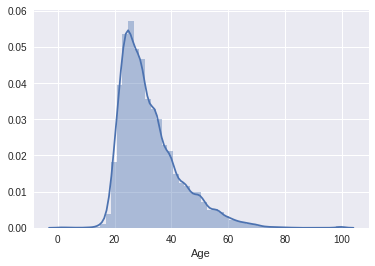

In [41]:
# 분포를 보는 그래프를 그려보자. 0살이라고 나온건 무시해야겠지?
# 대략 20대 근처가 많다
sns.distplot(mcq[mcq['Age'] > 0]['Age'])

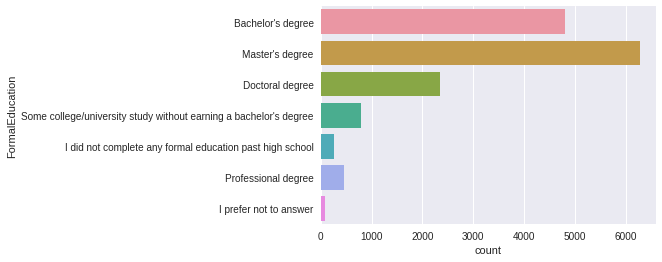

In [43]:
# 학력도 보자
# 석사 > 학사 > 박사 순서다. 
sns.countplot(y='FormalEducation', data=mcq)

In [45]:
# 전공을 보자 
# 그룹화 한 다음에 value_counts() 를 먹이면 전공을 알려주며, normalize=True 를 해주면 전체 데이터중의 비율을 알 수 있다.
mcq_major_count = pd.DataFrame(mcq['MajorSelect'].value_counts())
mcq_major_percent = pd.DataFrame(mcq['MajorSelect'].value_counts(normalize=True))

mcq_major_df = mcq_major_count.merge(mcq_major_percent, left_index=True, right_index=True)

mcq_major_df.columns = ['카운트', '비율']
mcq_major_df

,카운트,비율
Computer Science,4397,0.331074
Mathematics or statistics,2220,0.167156
Engineering (non-computer focused),1339,0.100821
Electrical Engineering,1303,0.098110
Other,848,0.063851
Physics,830,0.062495
"Information technology, networking, or system administration",693,0.052180
A social science,531,0.039982
Biology,274,0.020631
Management information systems,237,0.017845


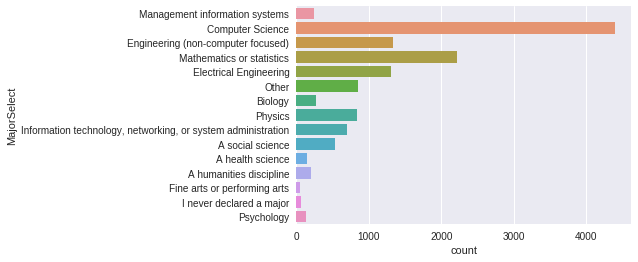

In [47]:
# 재학중인 사람의 전공만 볼까?
data = sns.countplot(y='MajorSelect', data=mcq)

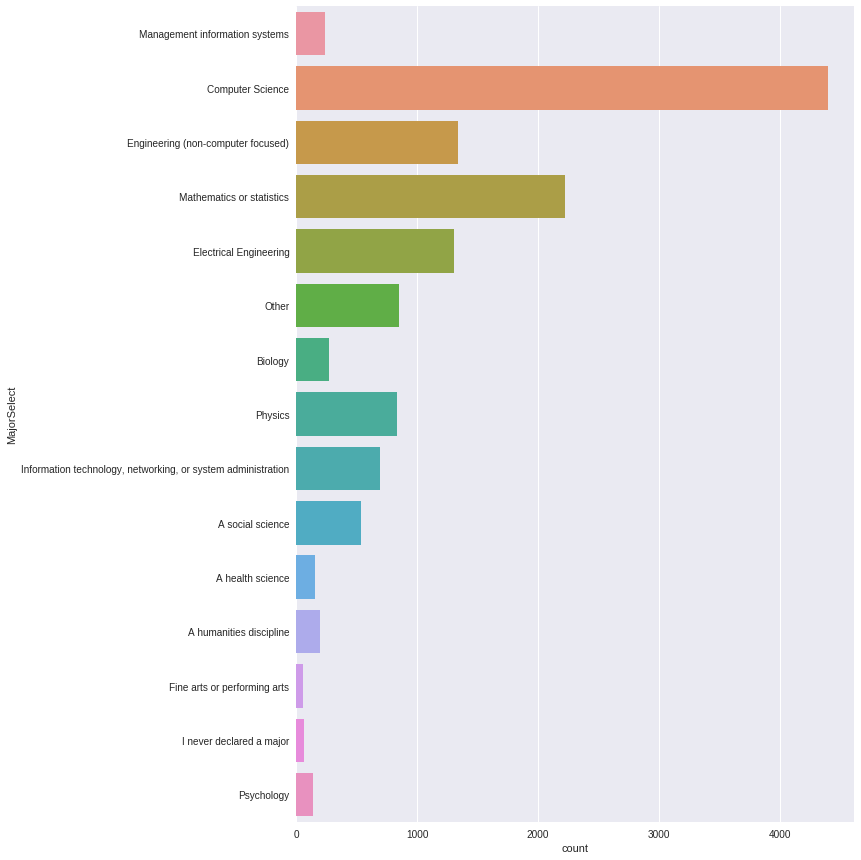

In [51]:
# 크기를 조금 크게?
plt.figure(figsize=(10,15))
sns.countplot(y='MajorSelect', data=mcq)

In [56]:
# 취업여부를 체크해보자
mcq_es_count = pd.DataFrame(mcq['EmploymentStatus'].value_counts())
mcq_es_percent = pd.DataFrame(mcq['EmploymentStatus'].value_counts(normalize=True))
mcq_es_df = mcq_es_count.merge(mcq_es_percent, left_index=True, right_index=True)
mcq_es_df.columns = ['응답수', '비율']
mcq_es_df['퍼센트'] = mcq_es_df['비율'] * 100
mcq_es_df

,응답수,비율,퍼센트
Employed full-time,10897,0.651890,65.189040
"Not employed, but looking for work",2110,0.126226,12.622637
"Independent contractor, freelancer, or self-employed",1330,0.079564,7.956449
"Not employed, and not looking for work",924,0.055276,5.527638
Employed part-time,917,0.054858,5.485762
I prefer not to say,420,0.025126,2.512563
Retired,118,0.007059,0.705911


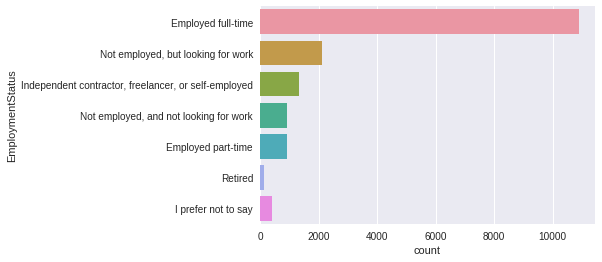

In [57]:
# SNS 으로 볼 수도 있겠다.
sns.countplot(y='EmploymentStatus', data=mcq)

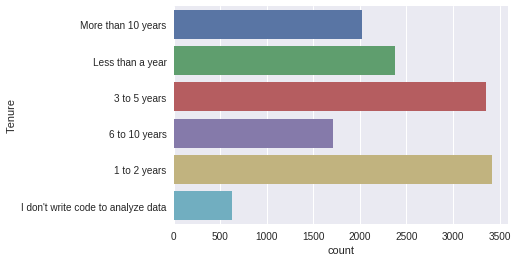

In [58]:
# 프로그래밍 경험 Tenure
sns.countplot(y='Tenure', data=mcq)

In [59]:
korea = mcq.loc[(mcq['Country'] =='South Korea')]
print ('The number of interviewees in Korea: ' + str(korea.shape[0]))
korea.shape

The number of interviewees in Korea: 194


(194, 228)

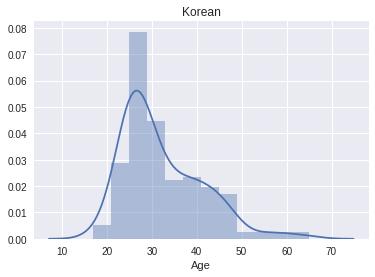

In [60]:
# 한국인은 194명이구나. 나이별로 그래프 그려볼까?
sns.distplot(korea['Age'].dropna())  # 값이 없는 경우는 날려버리기
plt.title('Korean')
plt.show()

In [63]:
korean_gender = pd.DataFrame(korea['GenderSelect'].value_counts())
korean_gender

,GenderSelect
Male,156
Female,37
A different identity,1


Text(0.5,1,u'Korean - Gender')

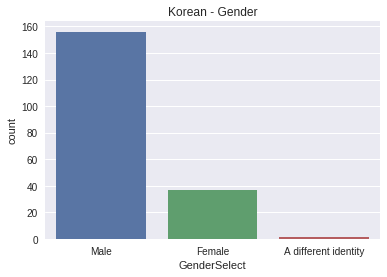

In [67]:
sns.countplot(x='GenderSelect', data=korea)
plt.title("Korean - Gender")

Text(0.5,1,u'Korean Male')

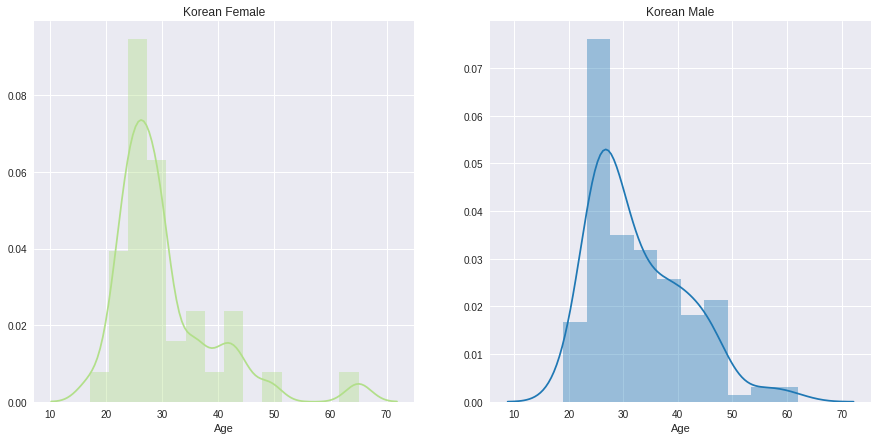

In [74]:
figure, (ax1, ax2) = plt.subplots(ncols=2)
figure.set_size_inches(15, 7)
sns.distplot(korea['Age'].loc[korea['GenderSelect'] =='Female'].dropna(), norm_hist=False, color=sns.color_palette("Paired")[2], ax = ax1)
ax1.set_title('Korean Female')
sns.distplot(korea['Age'].loc[korea['GenderSelect'] =='Male'].dropna(), norm_hist=False, color=sns.color_palette("Paired")[1], ax = ax2)
ax2.set_title('Korean Male')

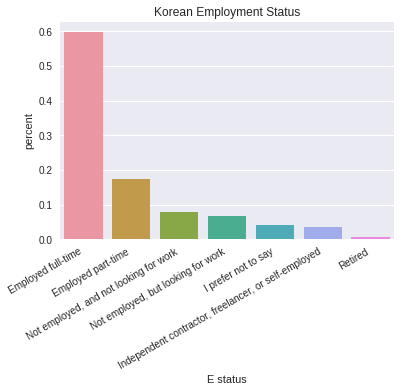

In [80]:
sns.barplot(x=korea['EmploymentStatus'].unique(), y=korea['EmploymentStatus'].value_counts()/len(korea))
plt.xticks(rotation=30, ha='right')
plt.title("Korean Employment Status")
plt.ylabel('percent')
plt.xlabel("E status")
plt.show()

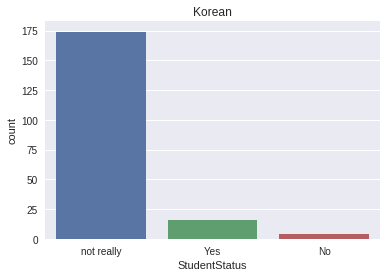

In [82]:
korea['StudentStatus'] = korea['StudentStatus'].fillna('No')
sns.countplot(x='StudentStatus', data = korea)
plt.title('Korean')
plt.show()

In [84]:
full_time = mcq.loc[(mcq['EmploymentStatus'] == 'Employed full-time')]
print(full_time.shape[0])
looking_for_job = mcq.loc[(mcq['EmploymentStatus'] == 'Not employed, but looking for work')]
print(looking_for_job.shape[0])

10897
2110


In [85]:
mcq.columns

Index([u'GenderSelect', u'Country', u'Age', u'EmploymentStatus',
       u'StudentStatus', u'LearningDataScience', u'CodeWriter',
       u'CareerSwitcher', u'CurrentJobTitleSelect', u'TitleFit',
       ...
       u'JobFactorExperienceLevel', u'JobFactorDepartment', u'JobFactorTitle',
       u'JobFactorCompanyFunding', u'JobFactorImpact', u'JobFactorRemote',
       u'JobFactorIndustry', u'JobFactorLeaderReputation',
       u'JobFactorDiversity', u'JobFactorPublishingOpportunity'],
      dtype='object', length=228)

In [87]:
mcq['Country'].value_counts()

United States                  4197
India                          2704
Other                          1023
Russia                          578
United Kingdom                  535
People 's Republic of China     471
Brazil                          465
Germany                         460
France                          442
Canada                          440
Australia                       421
Spain                           320
Japan                           277
Taiwan                          254
Italy                           238
Netherlands                     205
Ukraine                         196
South Korea                     194
Singapore                       184
Poland                          184
Pakistan                        161
Turkey                          144
Indonesia                       131
Switzerland                     129
South Africa                    127
Mexico                          126
Colombia                        113
Iran                        

In [88]:
india = mcq.loc[(mcq['Country'] == 'India')]
india.shape

(2704, 228)

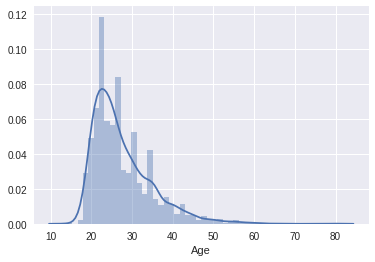

In [90]:
sns.distplot(india['Age'].dropna())